In [1]:
# libraries
%load_ext autoreload
%autoreload 2

import numpy as np
import soundfile as sf
import sounddevice as sd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

from scipy import signal, fft

from PDM2PCM import *
from PCM2PDM import *
from Serialize import *
from PlotSuite import *

In [2]:
def cic_compensator_response(c=2**13, N=3, R=10, M=1, order=31, cutoff=25, att=50, fs=1000, freq_points=512, plot=False, lang='en'): 
    # cic filter response
    freq_cic = np.arange(start=0, stop=0.5, step=1/(2*freq_points))
    spec_cic = np.zeros(len(freq_cic))
    spec_cic[1:] = (np.sin(np.pi*freq_cic[1:]*R*M) / np.sin(np.pi*freq_cic[1:]))**N # cic response
    spec_cic[0] = (R*M)**N # DC gain
    mag_cic = np.abs(spec_cic) # cic mag. response
    mag_cic = mag_cic/np.max(mag_cic) # cic mag. response norm.
    mag_cic_db = 20*np.log10(mag_cic) # cic mag. response db
    
    # ideal fir compensator response (inverse of cic)
    fir_freq_points = freq_points
    freq_fir = np.linspace(start=0, stop=1, num=fir_freq_points)
    freq_cic = np.arange(start=0, stop=np.round(fir_freq_points*cutoff/(fs/(2*R))))
    freq_cic = (1/R)*freq_cic/fir_freq_points
    inv_cic = np.zeros(len(freq_fir))
    inv_cic[1:len(freq_cic)] = 1/((1/(R*M)**N)*(np.sin(np.pi*freq_cic[1:]*R*M/2) / np.sin(np.pi*freq_cic[1:]/2))**N)
    inv_cic[0] = 1
    
    # actual fir compensator response
    fir_coeffs = signal.firwin2(numtaps=order, freq=freq_fir, gain=inv_cic, nyq=None, window=('chebwin',att))
    spec_comp_filt = fft.fft(fir_coeffs, 2*freq_points)
    spec_comp_filt = spec_comp_filt[:freq_points]
    mag_comp_filt = np.abs(spec_comp_filt)
    mag_comp_filt_db = 20*np.log10(mag_comp_filt)

    # cic mainlobe response
    cic_mainlobe_freq = 0.5*(2/R)*np.arange(start=0, stop=freq_points)/freq_points
    cic_mainlobe = np.zeros(len(cic_mainlobe_freq))
    cic_mainlobe[1:] = ((1/(R*M))*(np.sin(np.pi*cic_mainlobe_freq[1:]*R*M/2) / np.sin(np.pi*cic_mainlobe_freq[1:]/2)))**N
    cic_mainlobe[0] = 1

    # cascade filter response
    mag_cascaded_filt = np.abs(cic_mainlobe * spec_comp_filt)
    mag_cascaded_filt_db = 20*np.log10(mag_cascaded_filt)

    freq_desired_fir = np.arange(start=0, stop=fir_freq_points) * (fs/(2*R)) / (fir_freq_points)
    freq_actual_fir =  np.arange(start=0, stop=freq_points)     * (fs/(2*R)) / (freq_points)
    freq_cic =         np.arange(start=0, stop=freq_points)     * (fs/2)     / (freq_points)

    fir_coeffs = (fir_coeffs*c).astype(np.int16)

    if plot: 
        if lang=='en':
            fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(10,8))
            
            axs[0,0].semilogx(freq_actual_fir, mag_cascaded_filt_db, label="Cascaded Filter")
            axs[0,0].semilogx(freq_cic[freq_cic<=freq_actual_fir[-1]], mag_cic_db[freq_cic<=freq_actual_fir[-1]], label="CIC Filter")
            axs[0,0].semilogx(freq_actual_fir, mag_comp_filt_db, label="FIR Comp. Filter")
            
            axs[0,1].semilogx(freq_cic, mag_cic_db, label='CIC Filter')

            axs[1,0].stem(fir_coeffs, basefmt=" ", label='Coeff. FIR Comp. Filter')

            axs[1,1].semilogx(freq_desired_fir, inv_cic, label="Desired FIR resp.")
            axs[1,1].semilogx(freq_actual_fir, mag_comp_filt, label="Actual FIR resp.")

            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.4)

            axs[0,1].set_ylim([-70,2])
            axs[0,0].set_xlabel('Frequency (Hz)'), axs[0,1].set_xlabel('Frequency (Hz)'), axs[1,0].set_xlabel('Coefficient number'), axs[1,1].set_xlabel('Frequency (Hz)')
            axs[0,0].set_ylabel('Filter gain (dB)'), axs[0,1].set_ylabel('Filter gain (dB)'), axs[1,0].set_ylabel('Amplitude'), axs[1,1].set_ylabel('Filter gain')
            axs[0,0].legend(), axs[1,1].legend()
            axs[0,0].grid(True, which="both"), axs[0,1].grid(True, which="both"), axs[1,0].grid(True, which="both"), axs[1,1].grid(True, which="both")
            axs[0,0].set_title("Cascaded filter response"), axs[0,1].set_title("CIC filter response"), axs[1,0].set_title("Compensator FIR filter coefficients"), axs[1,1].set_title("Compensator FIR filter response")
        elif lang=='pt':
            fig, axs = plt.subplots(nrows=2, ncols=2, dpi=100, figsize=(10,8))
            
            axs[0,0].semilogx(freq_actual_fir, mag_cascaded_filt_db, label="Filtros em cascata", color='black', linestyle='solid')
            axs[0,0].semilogx(freq_cic[freq_cic<=freq_actual_fir[-1]], mag_cic_db[freq_cic<=freq_actual_fir[-1]], label="Filtro CIC", color='black', linestyle='dashdot')
            axs[0,0].semilogx(freq_actual_fir, mag_comp_filt_db, label="Filtro FIR Comp.", color='black', linestyle='dotted')
            
            axs[0,1].semilogx(freq_cic, mag_cic_db, label='Filtro CIC', color='black')

            axs[1,0].stem(fir_coeffs, basefmt=" ", label='Coeficientes do filtro FIR compensador', linefmt='black', markerfmt='ko')

            axs[1,1].semilogx(freq_desired_fir, inv_cic, label="Resposta desejada", color='black', linestyle='solid')
            axs[1,1].semilogx(freq_actual_fir, mag_comp_filt, label="Resposta real", color='black', linestyle='dashed')

            plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.25, hspace=.4)

            axs[0,1].set_ylim([-70,2])
            axs[0,0].set_xlabel('Frequência (Hz)'), axs[0,1].set_xlabel('Frequência (Hz)'), axs[1,0].set_xlabel('#Coeficientes'), axs[1,1].set_xlabel('Frequência (Hz)')
            axs[0,0].set_ylabel('Ganho do filtro (dB)'), axs[0,1].set_ylabel('Ganho do filtro (dB)'), axs[1,0].set_ylabel('Amplitude'), axs[1,1].set_ylabel('Ganho do filtro')
            axs[0,0].legend(), axs[1,1].legend()
            axs[0,0].grid(True, which="both"), axs[0,1].grid(True, which="both"), axs[1,0].grid(True, which="both"), axs[1,1].grid(True, which="both")
            axs[0,0].set_title("Resposta dos filtros em cascata"), axs[0,1].set_title("Resposta do filtro CIC"), axs[1,0].set_title("Coeficientes do filtro FIR compensador"), axs[1,1].set_title("Resposta do filtro FIR compensador")

            # np.set_printoptions(threshold=sys.maxsize, formatter={'int':hex})
    return fir_coeffs

In [11]:
len(pdm_stream_shrink)/5e6

0.2096576

SNR_1 = 44.008908, SNR_2 = 51.270710, SNR_3 = 65.498269


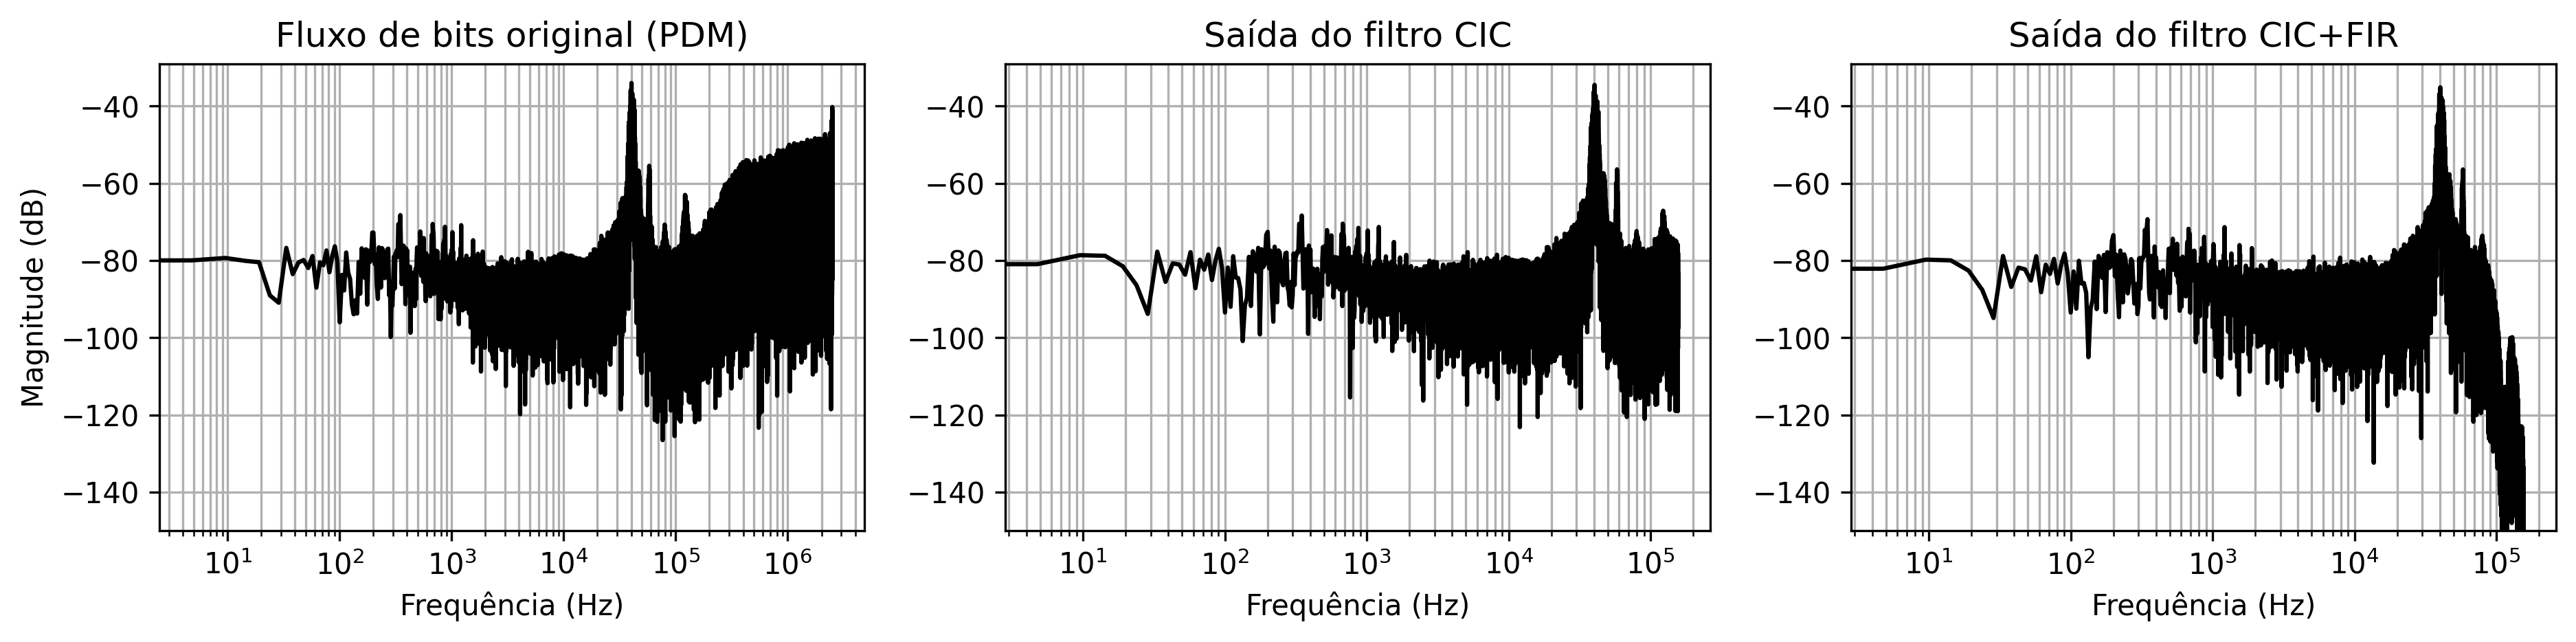

In [10]:
# wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/python/PDMSignalProcessing/data/"
# fname = "ultrasound_pdm_10_32bitsample_5000000hz"
wd = r"C:/Users/levyg/Documents/MEGA/Repositories/mems2sd_esp32/python/PDMSignalProcessing/PDM_C/fir_processing/"
fname = "clipped_data_bin"
fs_pdm = 5e6 # pdm sampling frequency
N = 2        # number of CIC stages
R = 16       # decimation rate
M = 1        # differential delay in the comb section stages of the filter
order = 64   # fir compensator order

data_pdm = np.fromfile(wd+fname, dtype=np.uint32)
pdm_stream = swap_bytes_of_word(data_pdm) # only necessary in Python

pdm_stream = pdm_stream.view(dtype=np.uint8).ravel()
pdm_stream = np.unpackbits(pdm_stream, axis=0).astype(np.int32)
pdm_stream_shrink = 2*pdm_stream-1

fir_coeffs = cic_compensator_response(c=2**6, N=N, R=R, M=M, order=order, cutoff=90e3, att=300, fs=fs_pdm, freq_points=512, plot=0, lang='pt')
cic_processed = CIC(decimation_factor=R, stages=N, differential_delay=M).process(pdm_stream_shrink)
cic_processed = cic_processed/np.max(cic_processed)
fir_processed = np.convolve(cic_processed, fir_coeffs, mode='full')
fir_processed = fir_processed/np.max(fir_processed)
pdm_cic_fir_plot(pdm_stream_shrink, cic_processed, fir_processed, fs_pdm, R, lang='pt')

In [7]:
# np.savetxt("PDM_C/fir_processing/clipped_data_bit", pdm_stream_shrink, fmt="%d")
# np.savetxt("PDM_C/fir_processing/python_fir_processed", fir_processed, fmt="%d")
# np.savetxt("PDM_C/fir_processing/python_cic_processed", cic_processed, fmt="%d")
np.savetxt("PDM_C/fir_processing/fir_coeffs", fir_coeffs, fmt="%d", newline=", ")

SNR_1 = 9.815292, SNR_2 = 3.416092, SNR_3 = 7.653529


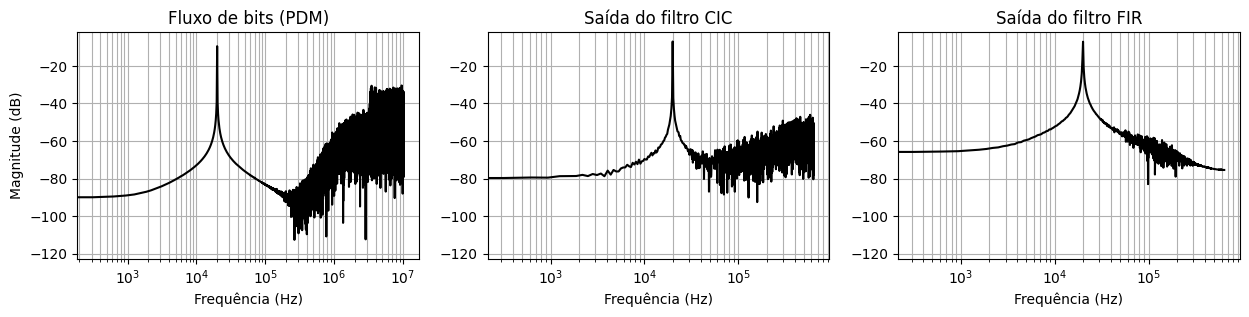

In [3]:
Fs = 20480000
N = 65537
pdm_stream = np.loadtxt('data/SD2.dat')

fir_coeffs = cic_compensator_response(N=4, R=16, M=2, order=16, cutoff=30e3, att=300, fs=Fs, freq_points=512, plot=False)
cic_processed = CIC().process(pdm_stream)
cic_processed = cic_processed/np.max(cic_processed)
fir_processed = np.convolve(cic_processed, fir_coeffs, mode='valid')
fir_processed = fir_processed/np.max(fir_processed)
pdm_cic_fir_plot(pdm_stream, cic_processed, fir_processed, Fs, 16, lang='pt')

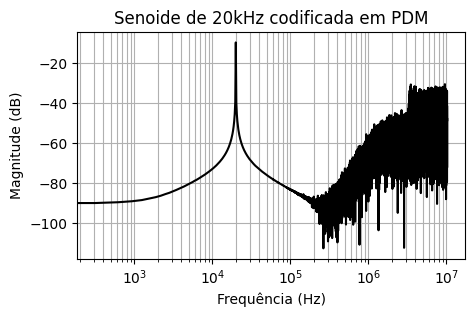

In [4]:
f, mag = get_mag(pdm_stream, Fs)

fig, axs = plt.subplots(nrows=1, ncols=1, dpi=100, figsize=(5,3))

axs.semilogx(f, mag, 'k')
axs.set_ylabel('Magnitude (dB)')
axs.set_xlabel('Frequência (Hz)')
axs.set_title('Senoide de 20kHz codificada em PDM')
axs.grid(True, which="both")

plt.show()